# Use `DiffTraj` to fit the Mean squared displacement (MSD) 

As a toy system, here we use the `DiffTraj` to fit a short MSD of water to introduce how to use it.

## First import the environment.

In [1]:
import sys
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import numpy as np
import jax
from jax import jit, value_and_grad, vmap, pmap, grad, vjp, tree_util, random
import jax.numpy as jnp
from dmff.api import Hamiltonian
from openmm import *
from openmm.app import * 
from openmm.unit import *
import pickle
from dmff.difftraj import Loss_Generator
from functools import partial
import optax
from dmff.optimize import MultiTransform, genOptimizer
import matplotlib.pyplot as plt

## Define the forcefield engine

In [2]:
rc = 0.7 # nm
dt = 0.0005 # ps
nsteps = 200
nout = 1
init_stru = 'water_nvt.pdb'

m_O = 15.99943
m_H = 1.007947
mass = jnp.tile(jnp.array([m_O, m_H, m_H]), 216)

pdb = PDBFile(init_stru)
ff = Hamiltonian('qspc-fw.xml')
pots = ff.createPotential(pdb.topology, nonbondedMethod=PME, nonbondedCutoff=rc*nanometer, rigidWater=False)
efunc = jit(pots.getPotentialFunc())
params = ff.getParameters().parameters
cov_map = pots.meta['cov_map']
box = jnp.array(pdb.topology.getPeriodicBoxVectors()._value)

ifile = open('init_state.pkl', 'rb')
init_state = pickle.load(ifile)
ifile.close()


## Define the `f_nout` and `L` function
`f_nout` is a function of state, which would be saved in traj, here, we want to save the position of oxygen atom. To use the function of gradient calculation in `DiffTraj`, we need to define the `L` function, which is a function of traj and returns the scalar loss.

In [3]:
@partial(vmap, in_axes=(0, 0, None), out_axes=(0))
def msd(pos0, pos1, box):
    box_inv = jnp.linalg.inv(box)
    dpos = pos1 - pos0
    ds = dpos.dot(box_inv)
    # pbc shift
    ds -= jnp.floor(ds + 0.5)
    dr = ds.dot(box)
    return jnp.average(jnp.sum(dr ** 2, axis=1))

line_ref = jnp.average(np.loadtxt('line_ref'), axis=1)

poss0 = jnp.array(init_state['pos'][:, ::3])
@jit
def L(traj):
    line = vmap(msd, in_axes=(None, 0, None), out_axes=(0))(poss0, traj, box)
    line = jnp.average(line, axis=1)
    return jnp.sum((line-line_ref)**2), line

@jit
def f_nout(state):
    return state['pos'][:, ::3]

## Use the Loss_Generator
Here the metadata is used to save the traj and auxiliary data (if have).

In [4]:
metadata = []
Generator = Loss_Generator(f_nout, box, init_state['pos'][0], mass, dt, nsteps, nout, cov_map, rc, efunc)
Loss = Generator.generate_Loss(L, has_aux=True, metadata=metadata)

## Optimize the forcefield

2024-03-21 11:15:08.067183: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.88 = f64[6,8,61326]{0,2,1} pad(f64[1,8,61326]{2,1,0} %broadcast.3004, f64[] %constant.13), padding=4_1x0_0x0_0, metadata={op_name="jit(vv_step)/jit(main)/transpose(jvp(jit(efunc)))/vmap(jit(pme_real_kernel))/jit(calc_e_perm)/scatter-add[dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1, 2), inserted_window_dims=(), scatter_dims_to_operand_dims=(2,)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.PROMISE_IN_BOUNDS update_consts=()]" source_file="/root/.local/lib/python3.10/site-packages/dmff/admp/pme.py" source_line=670}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.


Loop: 1
0.0003225696932243337 {'HarmonicAngleForce': {'angle': Array([0.00052098], dtype=float64), 'k': Array([1.75685922e-07], dtype=float64)}, 'HarmonicBondForce': {'k': Array([2.17905783e-10], dtype=float64), 'length': Array([-0.05079126], dtype=float64)}, 'NonbondedForce': {'epsilon': Array([2.89228251e-03, 1.45971341e+19], dtype=float64), 'sigma': Array([ 7.01299821e-02, -5.94657193e-12], dtype=float64)}}
{'HarmonicBondForce': {'length': Array([0.1], dtype=float64), 'k': Array([443153.3808], dtype=float64)}, 'HarmonicAngleForce': {'angle': Array([1.95476876], dtype=float64), 'k': Array([317.5656], dtype=float64)}, 'NonbondedForce': {'sigma': Array([0.3415492, 1.       ], dtype=float64), 'epsilon': Array([0.65029904, 0.        ], dtype=float64)}}


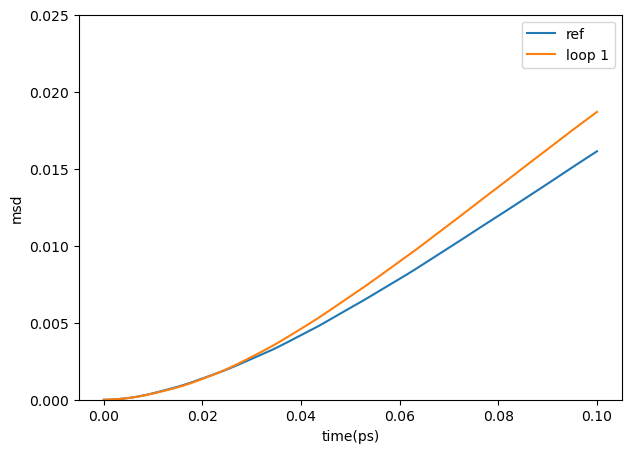

Loop: 2
8.733759808856746e-05 {'HarmonicAngleForce': {'angle': Array([0.00021723], dtype=float64), 'k': Array([8.29821975e-08], dtype=float64)}, 'HarmonicBondForce': {'k': Array([1.07954262e-10], dtype=float64), 'length': Array([-0.02624673], dtype=float64)}, 'NonbondedForce': {'epsilon': Array([1.11357039e-03, 6.74979261e+18], dtype=float64), 'sigma': Array([ 2.76664426e-02, -2.02187631e-11], dtype=float64)}}
{'HarmonicBondForce': {'length': Array([0.1], dtype=float64), 'k': Array([443153.3808], dtype=float64)}, 'HarmonicAngleForce': {'angle': Array([1.95476876], dtype=float64), 'k': Array([317.5656], dtype=float64)}, 'NonbondedForce': {'sigma': Array([0.33706692, 1.        ], dtype=float64), 'epsilon': Array([0.65029904, 0.        ], dtype=float64)}}


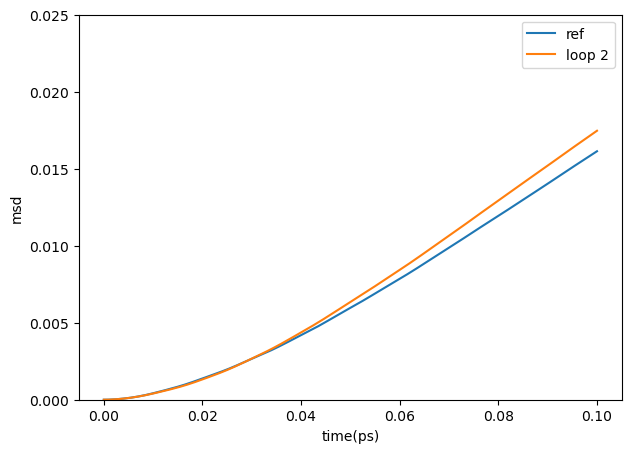

Loop: 3
1.3337496533350312e-05 {'HarmonicAngleForce': {'angle': Array([7.17081502e-05], dtype=float64), 'k': Array([3.40091431e-08], dtype=float64)}, 'HarmonicBondForce': {'k': Array([3.94870558e-11], dtype=float64), 'length': Array([-0.00962318], dtype=float64)}, 'NonbondedForce': {'epsilon': Array([3.05136361e-04, 2.39674189e+18], dtype=float64), 'sigma': Array([ 7.75986842e-03, -2.39357349e-11], dtype=float64)}}
{'HarmonicBondForce': {'length': Array([0.1], dtype=float64), 'k': Array([443153.3808], dtype=float64)}, 'HarmonicAngleForce': {'angle': Array([1.95476876], dtype=float64), 'k': Array([317.5656], dtype=float64)}, 'NonbondedForce': {'sigma': Array([0.33329304, 1.        ], dtype=float64), 'epsilon': Array([0.65029904, 0.        ], dtype=float64)}}


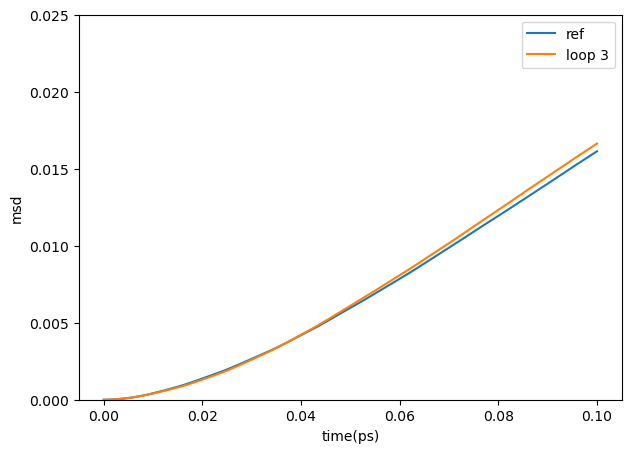

Loop: 4
3.6804596637044144e-07 {'HarmonicAngleForce': {'angle': Array([2.69536063e-06], dtype=float64), 'k': Array([1.43697332e-09], dtype=float64)}, 'HarmonicBondForce': {'k': Array([1.35122211e-12], dtype=float64), 'length': Array([-0.00033685], dtype=float64)}, 'NonbondedForce': {'epsilon': Array([8.13375660e-06, 8.01861899e+16], dtype=float64), 'sigma': Array([ 2.12355099e-04, -8.29123696e-13], dtype=float64)}}
{'HarmonicBondForce': {'length': Array([0.1], dtype=float64), 'k': Array([443153.3808], dtype=float64)}, 'HarmonicAngleForce': {'angle': Array([1.95476876], dtype=float64), 'k': Array([317.5656], dtype=float64)}, 'NonbondedForce': {'sigma': Array([0.33019361, 1.        ], dtype=float64), 'epsilon': Array([0.65029904, 0.        ], dtype=float64)}}


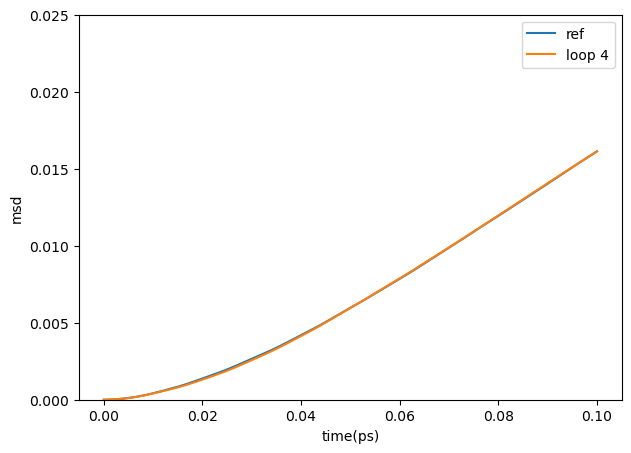

In [ ]:
params0 = params
params_choose = {'NonbondedForce': {'sigma': params0['NonbondedForce']['sigma'][0]}}

multiTrans = MultiTransform(params_choose)
multiTrans["NonbondedForce/sigma"] = genOptimizer(learning_rate=0.005, clip=0.05)
multiTrans.finalize()
grad_transform = optax.multi_transform(multiTrans.transforms, multiTrans.labels)
opt_state = grad_transform.init(params_choose)

nloops = 10
for nloop in range(1,nloops):
    v, g = value_and_grad(Loss, argnums=(1))(init_state, params)
    print('Loop:', nloop)
    print(v, g)
    gradient_choose = {'NonbondedForce': {'sigma': g['NonbondedForce']['sigma'][0]}}
    updates, opt_state = grad_transform.update(gradient_choose, opt_state, params=params_choose)
    params_choose = optax.apply_updates(params_choose, updates)
    params['NonbondedForce']['sigma'] = params['NonbondedForce']['sigma'].at[0].set(params_choose['NonbondedForce']['sigma'])
    print(params)
    
    line = metadata[-1]['aux_data']
    t = metadata[-1]['traj']['time']
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(t, line_ref, label='ref')
    ax.plot(t, line, label='loop %s'%nloop)
    ax.set_ylim((0, 0.025))
    ax.set_xlabel('time(ps)')
    ax.set_ylabel('msd')
    ax.legend()
    plt.savefig('compare_%s.png'%nloop, dpi=800)
    plt.show()
    plt.close()

